In [0]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
!pip install facenet-pytorch
from facenet_pytorch import InceptionResnetV1
from torch.autograd import Variable
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

     |████████████████████████████████| 1.9MB 4.8MB/s 
PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

training_dir = "/content/gdrive/My Drive/images_fer2013/Training"
validation_dir = "/content/gdrive/My Drive/images_fer2013/PublicTest"
testing_dir = "/content/gdrive/My Drive/images_fer2013/PrivateTest"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
num_classes = 7

In [0]:
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       ])

test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])


train_data = datasets.ImageFolder(training_dir,       
                    transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_data,
                   shuffle=True, batch_size=224)

validation_data = datasets.ImageFolder(validation_dir,       
                    transform=test_transforms)
validation_loader = torch.utils.data.DataLoader(validation_data,
                   shuffle=True, batch_size=64)

test_data = datasets.ImageFolder(testing_dir,       
                    transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data,
                   shuffle=True, batch_size=64)

print(train_loader.dataset.classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


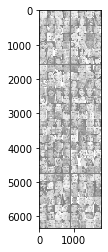

 Fear  Fear Surprise Happy


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % train_loader.dataset.classes[labels[j]] for j in range(4)))

In [0]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(89888, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        self.dout = nn.Dropout(p = 0.25)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.dout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.dout(x)
        x = flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),weight_decay = 0.005, lr=1e-5)
batch_size = 64
train_number_epochs = 15
num_workers = 8

In [0]:
train_counter = []
train_loss_history = []
train_iteration_number= 0
train_accuracy_history=[]

valid_counter = []
valid_loss_history = []
valid_iteration_number= 0
valid_accuracy_history = []

valid_loss_min = np.Inf

In [0]:
for epoch in range(0,train_number_epochs):
    train_class_correct = list(0 for i in range(num_classes))
    train_class_total = list(0 for i in range(num_classes))

    valid_class_correct = list(0 for i in range(num_classes))
    valid_class_total = list(0 for i in range(num_classes))

    running_val_accuracy = 0.0
    running_train_accuracy = 0.0
    running_loss = 0.0
    running_valid_loss = 0.0
    net.train()

    for i, data in enumerate(train_loader,0):
        
        img1 , label = data
        img1 , label = img1.cuda(), label.cuda()
  
        optimizer.zero_grad()
        output= net(img1)      
        _, pred= torch.max(output,1)
        
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        correct = pred.eq(label.view_as(pred))
        for j in range(len(label)):
                        target = label[j].data
                        train_class_correct[target] += correct[j].item()
                        train_class_total[target] += 1

        running_loss += (loss.item() * img1.size(0))
        train_accuracy = 100. * np.sum(train_class_correct) / np.sum(train_class_total)
        running_train_accuracy += (train_accuracy * img1.size(0))
        
        
        if i%50 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch+1,loss.item()))

            for i in range(num_classes):
                if train_class_total[i] > 0:
                        print('\nTraining Accuracy of %5s: %2d%% (%2d/%2d)' % (
                            str(i), 100 * train_class_correct[i] / train_class_total[i],
                            np.sum(train_class_correct[i]), np.sum(train_class_total[i])))

            print('\nTraining Accuracy (Overall): %2d%% (%2d/%2d)' % (
                100. * np.sum(train_class_correct) / np.sum(train_class_total),
                np.sum(train_class_correct), np.sum(train_class_total)))

    train_loss_history.append(running_loss / len(train_data))
    train_iteration_number +=1
    train_counter.append(train_iteration_number)
    train_accuracy_history.append(running_train_accuracy / len(train_data))

    net.eval()


    for i, data in enumerate(validation_loader,0):
     
        img1 , label = data
        img1 , label = img1.cuda(), label.cuda()
        
        output= net(img1)
        _, pred= output.max(1)
        
        loss = criterion(output,label)
        
        correct = pred.eq(label.view_as(pred))
        for j in range(len(label)):
                        target = label[j].data
                        valid_class_correct[target] += correct[j].item()
                        valid_class_total[target] += 1
        
        running_valid_loss += (loss.item() * img1.size(0))
        val_accuracy = 100. * np.sum(valid_class_correct) / np.sum(valid_class_total)
        running_val_accuracy += (val_accuracy * img1.size(0))               
        if i%50 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch+1,loss.item()))
       
            for i in range(num_classes):
                if train_class_total[i] > 0:
                        if valid_class_total[i] == 0:
                            valid_class_total[i] = valid_class_total[i]+0.000001
                        print('\nValidation Accuracy of %5s: %2d%% (%2d/%2d)' % (
                            str(i), 100 * valid_class_correct[i] / (valid_class_total[i]),
                            np.sum(valid_class_correct[i]), np.sum(valid_class_total[i])))

            print('\nValidation Accuracy (Overall): %2d%% (%2d/%2d)' % (
                100. * np.sum(valid_class_correct) / np.sum(valid_class_total),
                np.sum(valid_class_correct), np.sum(valid_class_total)))
            
    
    valid_loss_history.append(running_valid_loss / len(test_data))
    valid_iteration_number +=1
    valid_counter.append(valid_iteration_number)
    val = running_valid_loss / len(test_data) 
    print("Validation loss for epoch {}: {:.6f}".format(epoch+1,val))
    valid_accuracy_history.append(running_val_accuracy / len(test_data))
    if val <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val))
        torch.save(net, "/content/gdrive/My Drive/freshtrained.pth")
        valid_loss_min = val

Epoch number 1
 Current loss 1.9380131959915161


Training Accuracy of     0:  0% ( 0/37)

Training Accuracy of     1:  0% ( 0/ 4)

Training Accuracy of     2: 60% (20/33)

Training Accuracy of     3: 21% (12/55)

Training Accuracy of     4:  7% ( 3/40)

Training Accuracy of     5: 27% (10/36)

Training Accuracy of     6:  0% ( 0/19)

Training Accuracy (Overall): 20% (45/224)
Epoch number 1
 Current loss 1.6967469453811646


Training Accuracy of     0:  0% (14/1634)

Training Accuracy of     1:  0% ( 0/163)

Training Accuracy of     2: 15% (263/1665)

Training Accuracy of     3: 68% (1972/2865)

Training Accuracy of     4: 21% (424/1949)

Training Accuracy of     5: 19% (378/1895)

Training Accuracy of     6: 25% (321/1253)

Training Accuracy (Overall): 29% (3372/11424)
Epoch number 1
 Current loss 1.6046020984649658


Training Accuracy of     0:  4% (136/3163)

Training Accuracy of     1:  0% ( 0/337)

Training Accuracy of     2: 13% (447/3253)

Training Accuracy of     3: 70% (3994/5

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-pa

Epoch number 2
 Current loss 1.5530019998550415


Training Accuracy of     0:  7% ( 2/28)

Training Accuracy of     1:  0% ( 0/ 1)

Training Accuracy of     2: 17% ( 8/46)

Training Accuracy of     3: 64% (38/59)

Training Accuracy of     4: 59% (19/32)

Training Accuracy of     5: 21% ( 8/37)

Training Accuracy of     6: 57% (12/21)

Training Accuracy (Overall): 38% (87/224)
Epoch number 2
 Current loss 1.5512038469314575


Training Accuracy of     0: 16% (261/1621)

Training Accuracy of     1:  0% ( 0/167)

Training Accuracy of     2: 16% (267/1668)

Training Accuracy of     3: 73% (2102/2858)

Training Accuracy of     4: 45% (904/1982)

Training Accuracy of     5: 32% (630/1914)

Training Accuracy of     6: 50% (616/1214)

Training Accuracy (Overall): 41% (4780/11424)
Epoch number 2
 Current loss 1.4705551862716675


Training Accuracy of     0: 16% (519/3171)

Training Accuracy of     1:  0% ( 0/351)

Training Accuracy of     2: 16% (525/3236)

Training Accuracy of     3: 73% (4165/


 Loss History


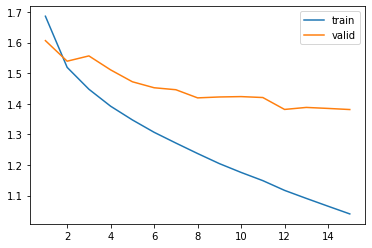


 Accuracy History


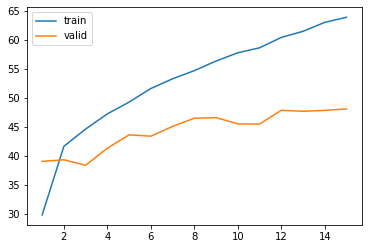

In [0]:
print('\n Loss History')
plt.plot(train_counter,train_loss_history, label="train")
plt.plot(valid_counter,valid_loss_history, label="valid")
plt.legend()
plt.show()

print('\n Accuracy History')
plt.plot(train_counter,train_accuracy_history, label="train")
plt.plot(valid_counter,valid_accuracy_history, label="valid")
plt.legend()
plt.show()

In [0]:
#Testing
test_class_correct = list(0 for i in range(num_classes))
test_class_total = list(0 for i in range(num_classes))
running_test_acc =0

net.eval()
for i, data in enumerate(test_loader,0):

    img1 , label = data
    img1 , label = img1.cuda(), label.cuda()

    output= net(img1)      
    _, pred= torch.max(output,1)
    correct = pred.eq(label.view_as(pred))

    for j in range(len(label)):
        target = label[j].data
        test_class_correct[target] += correct[j].item()
        test_class_total[target] += 1

        test_accuracy = 100. * np.sum(test_class_correct) / np.sum(test_class_total)
        running_test_acc += (test_accuracy * img1.size(0))

    if i%50 == 0:
        for i in range(num_classes):
            if test_class_total[i] > 0:
                print('\Testing Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    str(i), 100 * test_class_correct[i] / test_class_total[i],
                    np.sum(test_class_correct[i]),
                    np.sum(test_class_total[i])))




\Testing Accuracy of     0: 50% ( 3/ 6)
\Testing Accuracy of     1:  0% ( 0/ 1)
\Testing Accuracy of     2:  7% ( 1/14)
\Testing Accuracy of     3: 80% (16/20)
\Testing Accuracy of     4: 16% ( 2/12)
\Testing Accuracy of     5: 66% ( 4/ 6)
\Testing Accuracy of     6: 40% ( 2/ 5)
\Testing Accuracy of     0: 31% (139/445)
\Testing Accuracy of     1:  0% ( 0/51)
\Testing Accuracy of     2: 19% (90/466)
\Testing Accuracy of     3: 79% (641/809)
\Testing Accuracy of     4: 40% (228/570)
\Testing Accuracy of     5: 53% (289/545)
\Testing Accuracy of     6: 52% (199/378)


In [0]:

print('\nTesting Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(test_class_correct) / np.sum(test_class_total),
    np.sum(test_class_correct), np.sum(test_class_total)))
            